In [1]:
import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [4]:
with h5py.File('larger_dataset.hdf5', 'r') as f:
    [print(k) for k in f.keys()]

classical_X
classical_y
country_X
country_y
jazz_X
jazz_y
metal_X
metal_y
pop_X
pop_y
rap_X
rap_y
rock_X
rock_y


In [4]:
# load, combine

# order of load matters here! when removing duplicates (and there are ~1300), 
# the first ocurrance will be chosen. so I moved pop to the bottom because
# it's most general. and metal is second from last because i went deeper into
# the search results

with h5py.File('larger_dataset.hdf5', 'r') as f:
    X = f['classical_X'][:]
    y = f['classical_y'][:]
    
    X = np.concatenate((X, f['country_X'][:]))
    y = np.concatenate((y, f['country_y'][:]))
    X = np.concatenate((X, f['jazz_X'][:]))
    y = np.concatenate((y, f['jazz_y'][:]))
    X = np.concatenate((X, f['rap_X'][:]))
    y = np.concatenate((y, f['rap_y'][:]))
    X = np.concatenate((X, f['rock_X'][:]))
    y = np.concatenate((y, f['rock_y'][:]))
    X = np.concatenate((X, f['metal_X'][:]))
    y = np.concatenate((y, f['metal_y'][:]))
    X = np.concatenate((X, f['pop_X'][:]))
    y = np.concatenate((y, f['pop_y'][:]))
    
    
print(X.shape, y.shape)

(11023, 150, 150, 3) (11023,)


In [5]:
# dedupe
X, remove_indexes = np.unique(X, axis=0, return_index=True)
y = np.take(y, remove_indexes, axis=0)
print(X.shape, y.shape)

(9730, 150, 150, 3) (9730,)


In [6]:
# how many metal albums did we end up with?
y.sum()

3973.0

[0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.]


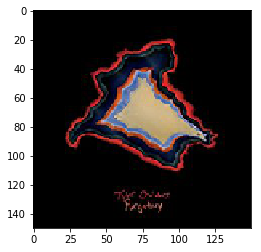

In [7]:
# viz a couple images to make sure they seem legit
from matplotlib.pyplot import imshow
print(y[:20])

imshow(X[19])

In [9]:
# re-save so I don't have to do this again
with h5py.File('larger_dataset.hdf5', 'a') as f:
    f['X'][...] = X
    f['y'][...] = y

In [10]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7784, 150, 150, 3) (1946, 150, 150, 3) (7784,) (1946,)


In [40]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout


base_model = keras.applications.xception.Xception(include_top=False, weights='imagenet',
                                                 input_shape=(150, 150, 3), pooling='avg')

x = base_model.output
x = Dropout(0.25)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

In [41]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_val, verbose=0)
        score = roc_auc_score(self.y_val, y_pred)
        print('epoch {}, ROC AUC: {}'.format(epoch, score))
        
roc = IntervalEvaluation(validation_data=(X_test, y_test))   

history = model.fit(X_train, y_train,
                   batch_size=256,
                   epochs=3,
                   verbose=1,
                   validation_data=(X_test, y_test),
                   callbacks=[roc])

Train on 7784 samples, validate on 1946 samples
Epoch 1/3
7784/7784 [==============================] - 49s 6ms/step - loss: 0.6609 - acc: 0.6233 - val_loss: 0.6611 - val_acc: 0.6876
epoch 0, ROC AUC: 0.7531229727706715
Epoch 2/3
7784/7784 [==============================] - 43s 6ms/step - loss: 0.5915 - acc: 0.6878 - val_loss: 0.7213 - val_acc: 0.6819
epoch 1, ROC AUC: 0.756085985018602
Epoch 3/3
7784/7784 [==============================] - 43s 6ms/step - loss: 0.5667 - acc: 0.7012 - val_loss: 0.7105 - val_acc: 0.6845
epoch 2, ROC AUC: 0.7533724779187944


In [43]:
y_pred = model.predict(X_test)
y_pred_classes = y_pred.round()

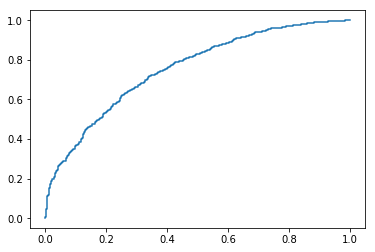

AUC: 0.7533724779187944


In [44]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresh = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.show()
print('AUC: {}'.format(roc_auc))

In [45]:
for i in range(400, 410):
    print(fpr[i], tpr[i], thresh[i])

0.32742616033755273 0.6885676741130092 0.1538981
0.32742616033755273 0.6898817345597897 0.1535994
0.32827004219409284 0.6898817345597897 0.15312351
0.32827004219409284 0.695137976346912 0.15172583
0.3291139240506329 0.695137976346912 0.15130167
0.3291139240506329 0.6977660972404731 0.15076315
0.3308016877637131 0.6977660972404731 0.15053973
0.3308016877637131 0.6990801576872536 0.15046915
0.3341772151898734 0.6990801576872536 0.1484421
0.3341772151898734 0.7017082785808147 0.14800277


Normalized confusion matrix
[[0.68607595 0.31392405]
 [0.32325887 0.67674113]]


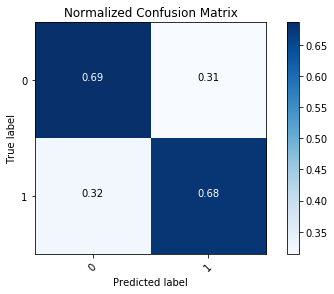

In [50]:
rounder = np.vectorize(lambda x: 0 if x <= 0.16 else 1)
y_new_thresh = rounder(y_pred)
confuse = confusion_matrix(y_test, y_new_thresh)
plot_confusion_matrix(confuse, classes=[0, 1], title='Normalized Confusion Matrix', normalize=True)
plt.show()

Normalized confusion matrix
[[0.92067511 0.07932489]
 [0.67805519 0.32194481]]


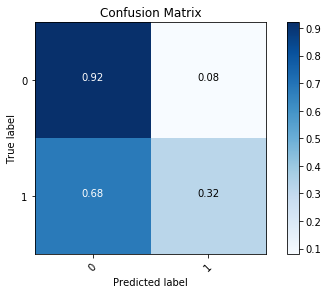

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

confuse = confusion_matrix(y_test, y_pred_classes)
plot_confusion_matrix(confuse, classes=[0, 1], title='Confusion Matrix', normalize=True)
plt.show()

In [51]:
import numpy as np
import requests
from io import BytesIO
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline

def get_image_data(url):
    r = requests.get(url)
    img = Image.open(BytesIO(r.content))
    img = img.resize((150, 150))
    array = np.asarray(img) / 255
    array = array.astype('float32')
    
    return array

array = get_image_data('http://www.nowcultured.com/images/2013/11/60-creative-metal-album-covers/megadeth-rust-in-peace.jpg')
model.predict(np.expand_dims(array, axis=0))

array([[0.27094135]], dtype=float32)

In [52]:
# model has threshold of 0.16
model.save('new_dataset_model.hdf5')